In [3]:
import pandas as pd
import numpy as np

In [6]:
stores = pd.read_csv('1_stores_corrupted_cleaned.csv')
products = pd.read_csv('2_products_corrupted_cleaned.csv')
customers = pd.read_csv('3_customers_corrupted_cleaned.csv')
promotions = pd.read_csv('4_promotions_corrupted_cleaned.csv')
sales_header = pd.read_csv('6_sales_headers_corrupted_cleaned.csv')
sales_line_items = pd.read_csv('7_sales_line_items_corrupted_cleaned.csv')

In [8]:
products.head()

,product_id,product_name,product_category,unit_price,current_stock_level
0,P001,Spices Mix 8,Grocery,128,307
1,P002,Wheat Flour 13,Grocery,604,855
2,P003,Salt 7,Grocery,261,461
3,P004,Sugar 6,Grocery,366,459
4,P005,Mixed Pulses 12,Grocery,738,319


In [11]:
products.isnull().sum()

product_id             0
product_name           0
product_category       0
unit_price             0
current_stock_level    0
dtype: int64

In [9]:
stores.head()

,store_id,store_name,store_city,store_region,opening_date
0,S001,Grand Bazaar 1,Indore,East,23-08-2017
1,S002,Prime Retail 2,Kolkata,West,27-12-2020
2,S003,Tech Valley 3,Lucknow,Central,21-08-2018
3,S004,Grand Bazaar 4,Jaipur,Unknown,31-10-2021
4,S005,Eastern Bazaar 5,Chennai,East,08-05-2017


In [10]:
stores.isnull().sum()

store_id        0
store_name      0
store_city      0
store_region    0
opening_date    0
dtype: int64

In [12]:
sales_header.isnull().sum()

transaction_id      0
customer_id         0
store_id            0
transaction_date    0
total_amount        0
customer_phone      0
dtype: int64

In [13]:
sales_line_items.isnull().sum()

line_item_id        0
transaction_id      0
product_id          0
promotion_id        0
quantity            0
line_item_amount    0
dtype: int64

In [17]:
import pandas as pd

# ---- Perform JOINs (SQL equivalent) ----
df = (
    sales_line_items
    .merge(sales_header, on="transaction_id", how="left")
    .merge(products, on="product_id", how="left")
    .merge(stores, on="store_id", how="left")
)

# ---- Grouping and Aggregation (SQL GROUP BY equivalent) ----
result = (
    df.groupby(["store_name", "product_name", "product_category", "current_stock_level"], dropna=False)
      .agg(
            total_quantity_sold=("quantity", "sum"),
            total_sales_value=("line_item_amount", "sum")
      )
      .reset_index()
)

# ---- Compute stock-to-sales ratio ----
result["stock_to_sales_ratio"] = (
    result["total_quantity_sold"] /
    result["current_stock_level"].replace({0: None})
).round(2)

# ---- Sort DESC like ORDER BY in SQL ----
result = result.sort_values(by="total_quantity_sold", ascending=False).dropna()

result.head(20)  # show sample output

,store_name,product_name,product_category,current_stock_level,total_quantity_sold,total_sales_value,stock_to_sales_ratio
242,Mega Store 113,Energy Drink 12,Beverages,97.0,991,-989,10.22
357,Prime Retail 50,Power Bank 4,electonics,431.0,667,0,1.55
512,Urban Hub 8,LED TV 18,Electronics,940.0,471,14677,0.50
440,Super Mart 7,LED TV 18,Electronics,940.0,471,14677,0.50
314,Prime Retail 112,T-Shirt 7,Clothing,351.0,9,6874,0.03
123,Eastern Bazaar 101,Sports Shoes 16,Clothing,332.0,8,4066,0.02
202,Grand Bazaar 136,Cake 17,Snacks,311.0,8,456,0.03
166,Elite Store 189,Chocolate Bar 3,Snacks,668.0,7,927,0.01
515,Valley Market 110,Cake 8,Snacks,-15.0,7,513,-0.47
83,City Plaza 188,Track Suit 5,Clothing,398.0,7,17133,0.02


In [22]:
#Interpretation

# SSR Value	         Meaning	                             Insight
# High (>1)	        Sales > Stock	          Customer demand is higher than stock available → risk of stockout
# Moderate (0.3–1)	  Balanced	          Stock aligns well with sales → good store planning
# Low (<0.3)	       Stock > Sales	              Overstock → inventory is not aligned with customer buying behavior

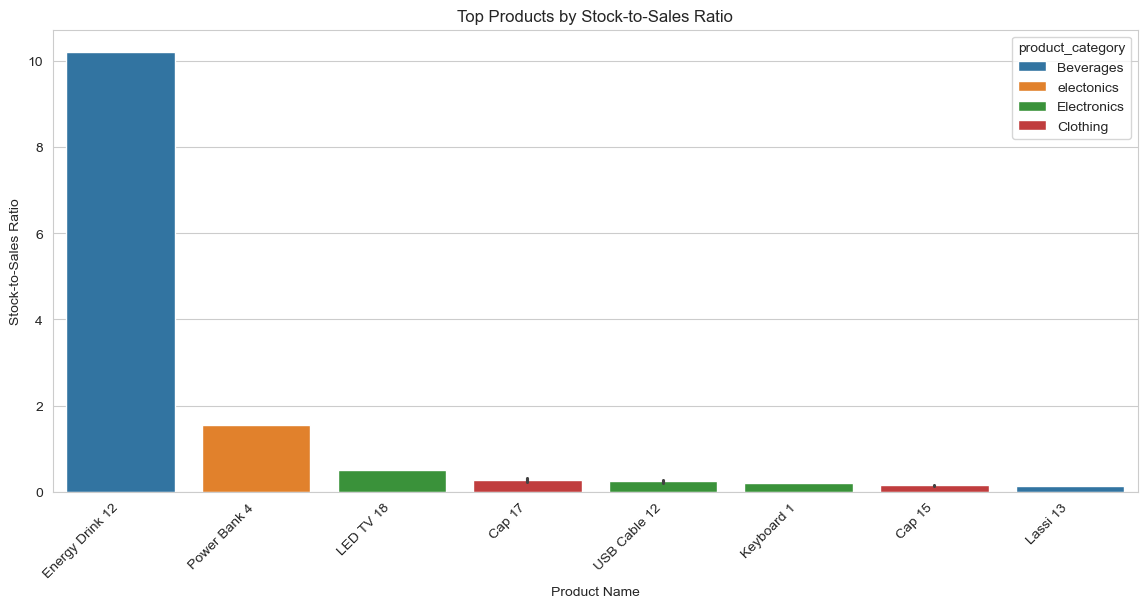

In [21]:


top_ratio = result.sort_values("stock_to_sales_ratio", ascending=False).head(15)

plt.figure(figsize=(14,6))
sns.barplot(
    data=top_ratio,
    x="product_name",
    y="stock_to_sales_ratio",
    hue="product_category"
)

plt.xticks(rotation=45, ha="right")
plt.title("Top Products by Stock-to-Sales Ratio")
plt.ylabel("Stock-to-Sales Ratio")
plt.xlabel("Product Name")
plt.show()